# try an image based approach
This code was generated from code from EEGLearn

In [3]:
import mne
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.realpath(".."))
import util_funcs, constants

Using TensorFlow backend.


In [4]:
import data_reader as read

In [5]:
data = read.edf_eeg_2_df("/home/ms994/v1.5.0/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.edf", resample=pd.Timedelta(seconds=1/250))[util_funcs.get_common_channel_names()]

## some code that sets up image generation

In [6]:
import math as m
import numpy as np
import scipy.io
from scipy.interpolate import griddata
from sklearn.preprocessing import scale
from functools import reduce
def gen_images(locs, features, n_gridpoints=32, normalize=True, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode
    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] // nElectrodes
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])  # features.shape为[samples, 3*nElectrodes]

    nSamples = features.shape[0]    # sample number 2670
    # Interpolate the values        # print(np.mgrid[-1:1:5j]) get [-1.  -0.5  0.   0.5  1. ]
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))

    
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),    # cubic
                                    method='cubic', fill_value=np.nan)
    
#     # Normalizing
#     for c in range(n_colors):
#         if normalize:
#             temp_interp[c][~np.isnan(temp_interp[c])] = \
#                 scale(temp_interp[c][~np.isnan(temp_interp[c])])
        
#         temp_interp[c] = np.nan_to_num(temp_interp[c])
        
    temp_interp = np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H] # WH xy
    temp_interp = np.swapaxes(temp_interp, 1, 2)
    temp_interp = np.swapaxes(temp_interp, 2, 3)    # [samples, W, H，colors]
    return temp_interp
def cart2sph(x, y, z):
    """
    Transform Cartesian coordinates to spherical
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :return: radius, elevation, azimuth
    """
    x2_y2 = x**2 + y**2
    r = m.sqrt(x2_y2 + z**2)                    # r     tant^(-1)(y/x)
    elev = m.atan2(z, m.sqrt(x2_y2))            # Elevation
    az = m.atan2(y, x)                          # Azimuth
    return r, elev, az


def pol2cart(theta, rho):
    """
    Transform polar coordinates to Cartesian 
    :param theta: angle value
    :param rho: radius value
    :return: X, Y
    """
    return rho * m.cos(theta), rho * m.sin(theta)

def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.
    :param pos: position in 3D Cartesian coordinates    [x, y, z]
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)

In [7]:
locations = pd.read_csv("../assets/3d_positions.csv")

In [8]:
locations = pd.read_csv("../assets/3d_positions.csv")
projections = pd.DataFrame(locations[["x", "y", "z"]].apply(lambda x: azim_proj(x), axis=1).tolist(), columns=["x_proj", "y_proj"])

In [9]:
locations = pd.read_csv("../assets/3d_positions.csv")
projections = pd.DataFrame(locations[["x", "y", "z"]].apply(lambda x: azim_proj(x), axis=1).tolist(), columns=["x_proj", "y_proj"])
projections.loc[:,"channels"] = locations.label

## test with a sample data segment

In [10]:
data = data.values[0:10000]

In [11]:
data.shape

(10000, 21)

In [12]:
dataSnapShot = data[0]
dataSnapShot.shape

(21,)

In [13]:
def gen_image_from_snapshot(snapshot):
    return np.nan_to_num(gen_images(projections[["x_proj", "y_proj"]].values, snapshot.reshape(1,21),  n_gridpoints=16).reshape((16,16)))

In [14]:
transformed = np.apply_along_axis(gen_image_from_snapshot, 1, data)

In [15]:
transformed.shape

(10000, 16, 16)

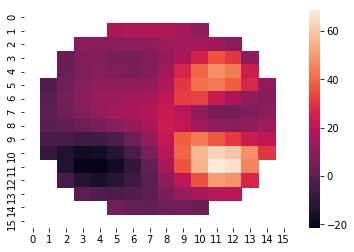

In [16]:
import seaborn as sns
data = gen_images(projections[["x_proj", "y_proj"]].values, dataSnapShot.reshape(1,21), n_gridpoints=16).reshape((16,16)) 
sns.heatmap(data)

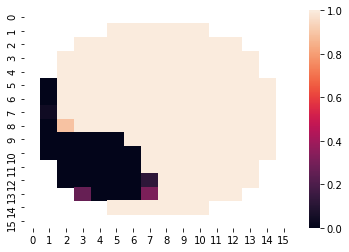

In [17]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import HTML

%matplotlib inline


fig = plt.figure()

def init():
    plt.clf()
    ax = sns.heatmap(data, vmin=0, vmax=1)

def animate(i):
    plt.clf()
    data = transformed[i]
    ax = sns.heatmap(data, vmin=-100, vmax=100)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=100)
HTML(anim.to_html5_video())


In [18]:
%%bash
cat  /home/ms994/v1.5.0/edf/train/01_tcp_ar/121/00012185/s002_2015_05_20/00012185_s002_t000.tse_bi

version = tse_v1.0.0

0.0000 1290.0000 bckg 1.0000


In [19]:
dataSnapShot.max()

70.19388

## Try a matrix transform
Using np.applyalongaxis takes significantly longer than expected to run. Using a matrix transform may be more useful

In [20]:
identity = np.identity(21)

In [21]:
transform = np.apply_along_axis(gen_image_from_snapshot, 1, identity)

In [22]:
data = read.edf_eeg_2_df("/home/ms994/v1.5.0/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.edf", resample=pd.Timedelta(seconds=1/250))[util_funcs.get_common_channel_names()]

In [23]:
data.values.shape

(301250, 21)

In [24]:
data.values.shape, transform.shape

((301250, 21), (21, 16, 16))

In [25]:
transformed_data = np.matmul(data.values, transform.reshape(21,-1))

In [26]:
transformed_data = transformed_data.reshape((-1, 16,16))

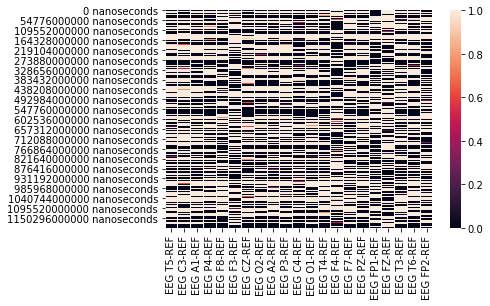

In [27]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import HTML

%matplotlib inline


fig = plt.figure()

def init():
    plt.clf()
    ax = sns.heatmap(data, vmin=0, vmax=1)

def animate(i):
    plt.clf()
    data = transformed_data[0:10000][i]
    ax = sns.heatmap(data, vmin=-100, vmax=100)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=100)
HTML(anim.to_html5_video())

# Create a TF records mapping function for this
We are going to read in 1000 by 21 and map into a 1000 by 16 by 16 images on the GPU Level

In [28]:
import tensorflow as tf
transform_tf = tf.constant(transform.reshape(21,-1))

In [29]:
transform_tf

<tf.Tensor 'Const:0' shape=(21, 256) dtype=float64>

In [30]:
from preprocessingV2 import tfrecord_mappers as tfm

In [31]:
def map_example_to_instance(example):
    data = tf.reshape(example['data'], [1000,21,1])
    # data = (example['data'])

    class_label = tf.cast(example['label'], tf.int32)
    transform_v2 = tf.constant(transform.reshape(21,-1))

    # del example    dataset = dataset.map(lambda x: 
    data = tf.reshape(example["data"], (1000,21))
    data = tf.matmul(tf.cast(data, tf.float64), transform_v2)
    data = tf.reshape(data, (1000,16,16,1))
    return data, (tf.one_hot(class_label[0], 2), tf.one_hot(example["subtypeLabel"][0], 4),  example["montage"])


def get_batched_dataset(filenames, batch_size=64, max_queue_size=12,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)

    dataset = dataset.map(tfm.read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.map(map_example_to_instance)



    
    
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory
    return dataset

In [32]:
train_data = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"],  is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"],  is_train=False)

In [26]:
g_noise = 1
num_cnn_layers = 3
loss_weights = [1,1,1] 
num_lstm_layers = 1
num_lin_layers = 4 
lstm_h = 4
cnn2d_n_k = 1 
lin_h = 64 
lr = 0.001
inputLayer = tf.keras.layers.Input((1000,16,16, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(g_noise)(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.Conv3D(cnn2d_n_k, (3,3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool3D((2,2,2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3]) * int(x.shape[4]),), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(lstm_h, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened
for k in range(num_lin_layers):
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)


#seizure classify
x = x_shared_flattened
for k in range(num_lin_layers):
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
x_classify = tf.keras.layers.Dense(4, name="classify", activation="softmax")(x)

#montage classify
x = x_shared_flattened
for k in range(num_lin_layers):
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
x_montage = tf.keras.layers.Dense(22, name="montage", activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect, x_classify, x_montage, ])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=lr), loss_weights=loss_weights, loss=["categorical_crossentropy", "categorical_crossentropy", "binary_crossentropy", ], metrics={"detect":["accuracy", f1, sensitivity, specificity], "classify":["accuracy"], "montage":["binary_accuracy"], })
batch_size=128
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 16, 16, 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 1000, 16, 16, 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 1000, 16, 16, 28          gaussian_noise[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReL

In [95]:
tf.test.is_gpu_available()

True

In [27]:
batch_size=64
train_steps=int(203894/batch_size)
valid_steps=int(81251/batch_size)
test_steps=int(129670/batch_size)

train_steps=1000
valid_steps=500
test_steps=int(129670/batch_size)

num_epochs=100
verbose=1
def get_model_checkpoint(model_name="seiz_3d.h5", early_stopping_on="val_loss", mode="auto"):
    return tf.keras.callbacks.ModelCheckpoint(model_name, monitor=early_stopping_on, save_best_only=True, verbose=1, mode=mode)
def get_early_stopping(patience=25, early_stopping_on="val_loss", mode="auto"):
    return tf.keras.callbacks.EarlyStopping(patience=patience, verbose=1, min_delta=0.001, monitor=early_stopping_on, mode=mode)
def get_reduce_lr(early_stopping_on="val_loss", reduce_lr_patience=5, mode="auto"):
    return tf.keras.callbacks.ReduceLROnPlateau(monitor=early_stopping_on, patience=reduce_lr_patience, mode=mode)
def get_cb_list():
    return [get_model_checkpoint(), get_early_stopping(), get_reduce_lr()]

history = model.fit(
        train_data,
        steps_per_epoch=(train_steps),
        validation_data=valid_data,
        validation_steps=(valid_steps),
        epochs=num_epochs,
        callbacks=get_cb_list(),
        class_weight={"detect":[1,12]},
        verbose=verbose)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 1.5255 - detect_loss: 0.3265 - classify_loss: 0.4636 - montage_loss: 0.2298 - detect_acc: 0.8860 - detect_f1: 0.0613 - detect_sensitivity: 0.0659 - detect_specificity: 0.9258 - classify_acc: 0.8648 - montage_binary_accuracy: 0.9178
Epoch 00001: val_loss improved from inf to 0.74106, saving model to seiz_3d.h5
1000/1000 [==============================] - 370s 370ms/step - loss: 1.5244 - detect_loss: 0.3263 - classify_loss: 0.4634 - montage_loss: 0.2297 - detect_acc: 0.8860 - detect_f1: 0.0612 - detect_sensitivity: 0.0658 - detect_specificity: 0.9258 - classify_acc: 0.8649 - montage_binary_accuracy: 0.9179 - val_loss: 0.7411 - val_detect_loss: 0.3111 - val_classify_loss: 0.2404 - val_montage_loss: 0.1589 - val_detect_acc: 0.9279 - val_detect_f1: 0.0075 - val_detect_sensitivity: 0.0058 - val_detect_specificity: 0.9418 - val_classify_acc: 0.9531 - val_montage_binary_accu

Epoch 10/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.4934 - detect_loss: 0.1742 - classify_loss: 0.2128 - montage_loss: 0.1001 - detect_acc: 0.9365 - detect_f1: 0.4099 - detect_sensitivity: 0.3266 - detect_specificity: 0.9457 - classify_acc: 0.9291 - montage_binary_accuracy: 0.9649
Epoch 00010: val_loss did not improve from 0.61619
1000/1000 [==============================] - 351s 351ms/step - loss: 0.4932 - detect_loss: 0.1741 - classify_loss: 0.2127 - montage_loss: 0.1000 - detect_acc: 0.9365 - detect_f1: 0.4099 - detect_sensitivity: 0.3267 - detect_specificity: 0.9458 - classify_acc: 0.9291 - montage_binary_accuracy: 0.9649 - val_loss: 0.6734 - val_detect_loss: 0.3099 - val_classify_loss: 0.2249 - val_montage_loss: 0.1320 - val_detect_acc: 0.9173 - val_detect_f1: 0.1186 - val_detect_sensitivity: 0.1129 - val_detect_specificity: 0.9474 - val_classify_acc: 0.9477 - val_montage_binary_accuracy: 0.9655
Epoch 11/100
 999/1000 [============================>.] - ETA:

KeyboardInterrupt: 

Appears the network takes awhile to run. Might want to further reduce number of parameters somehow and try cnn only with one outpu
# Try to reduce the network complexity

In [33]:
import tensorflow as tf

In [36]:
transform.shape

(21, 16, 16)

In [34]:
from preprocessingV2 import tfrecord_mappers as tfm

In [37]:
def map_example_to_instance(example):
    data = tf.reshape(example['data'], [1000,21,1])
    # data = (example['data'])

    class_label = tf.cast(example['label'], tf.int32)
    transform_v2 = tf.constant(transform.reshape(21,-1))

    # del example    dataset = dataset.map(lambda x: 
    data = tf.reshape(example["data"], (1000,21))
    data = tf.matmul(tf.cast(data, tf.float64), transform_v2)
    data = tf.reshape(data, (1000,16,16,1))
    return data, tf.one_hot(class_label[0], 2)


def get_batched_dataset(filenames, batch_size=64, max_queue_size=40,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)

    dataset = dataset.map(tfm.read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.map(map_example_to_instance)



    
    
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory
    return dataset

In [38]:
train_data = get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"],  batch_size=64, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], batch_size=64, is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], batch_size=64, is_train=False)

In [30]:
g_noise = 1
num_cnn_layers = 3
loss_weights = [1,1,1] 
num_lstm_layers = 1
num_lin_layers = 3 
lstm_h = 16
cnn2d_n_k = 1 
lin_h =16
lr = 0.001
inputLayer = tf.keras.layers.Input((1000,16,16, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(g_noise)(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.Conv3D(cnn2d_n_k, (3,3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool3D((2,2,2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3]) * int(x.shape[4]),), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(lstm_h, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened
for k in range(num_lin_layers):
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect,])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=lr), loss=["categorical_crossentropy"], metrics=["accuracy", f1, sensitivity, specificity])
batch_size=128
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000, 16, 16, 1)   0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 1000, 16, 16, 1)   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1000, 16, 16, 1)   28        
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 1000, 16, 16, 1)   0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 500, 8, 8, 1)      0         
_________________________________________________________________
batch_normalization_v1_17 (B (None, 500, 8, 8, 1)      4         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 500, 8, 8, 1)      28        
__________

In [95]:
tf.test.is_gpu_available()

True

In [31]:
batch_size=64
train_steps=int(203894/batch_size)
valid_steps=int(81251/batch_size)
test_steps=int(129670/batch_size)

train_steps=1000
valid_steps=500
test_steps=int(129670/batch_size)

num_epochs=1000
verbose=1
def get_model_checkpoint(model_name="seiz_3d_1output.h5", early_stopping_on="val_loss", mode="auto"):
    return tf.keras.callbacks.ModelCheckpoint(model_name, monitor=early_stopping_on, save_best_only=True, verbose=1, mode=mode)
def get_early_stopping(patience=10, early_stopping_on="val_loss", mode="auto"):
    return tf.keras.callbacks.EarlyStopping(patience=patience, verbose=1, min_delta=0.001, monitor=early_stopping_on, mode=mode)
def get_reduce_lr(early_stopping_on="val_loss", reduce_lr_patience=5, mode="auto"):
    return tf.keras.callbacks.ReduceLROnPlateau(monitor=early_stopping_on, patience=reduce_lr_patience, mode=mode)
def get_cb_list():
    return [get_model_checkpoint(), get_early_stopping(), get_reduce_lr()]

history = model.fit(
        train_data,
        steps_per_epoch=(train_steps),
        validation_data=valid_data,
        validation_steps=(valid_steps),
        epochs=num_epochs,
        callbacks=get_cb_list(),
        class_weight={"detect":[1,12]},
        verbose=verbose)

Epoch 1/1000
 999/1000 [============================>.] - ETA: 0s - loss: 0.8128 - acc: 0.8833 - f1: 0.1126 - sensitivity: 0.1314 - specificity: 0.9302
Epoch 00001: val_loss improved from inf to 0.27668, saving model to seiz_3d_1output.h5
1000/1000 [==============================] - 349s 349ms/step - loss: 0.8123 - acc: 0.8833 - f1: 0.1125 - sensitivity: 0.1312 - specificity: 0.9301 - val_loss: 0.2767 - val_acc: 0.9242 - val_f1: 0.0416 - val_sensitivity: 0.0335 - val_specificity: 0.9432
Epoch 2/1000
 999/1000 [============================>.] - ETA: 0s - loss: 0.2279 - acc: 0.9253 - f1: 0.1233 - sensitivity: 0.0836 - specificity: 0.9308
Epoch 00002: val_loss did not improve from 0.27668
1000/1000 [==============================] - 332s 332ms/step - loss: 0.2279 - acc: 0.9253 - f1: 0.1235 - sensitivity: 0.0837 - specificity: 0.9307 - val_loss: 0.3125 - val_acc: 0.9269 - val_f1: 0.0180 - val_sensitivity: 0.0137 - val_specificity: 0.9415
Epoch 3/1000
 999/1000 [============================

Epoch 00018: early stopping


In [33]:
import pickle as pkl
pkl.dump(history.history, open("history.pkl", "wb"))

##  Try to resample, go ahead and use a balanced train set with this as well, increase number of Dense layer parameters

In [53]:
def get_positive_train_dataset(filenames, random_rearrange_each_batch=False, max_queue_size=10, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)
    
    dataset = dataset.map(tfm.read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.map(map_example_to_instance)
    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(tf.cast(y, tf.int32), 0), 1))


#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

def get_negative_train_dataset(filenames, random_rearrange_each_batch=False, max_queue_size=10, n_process=4, is_train=True):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=n_process)
    
    dataset = dataset.map(tfm.read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.map(map_example_to_instance)

    dataset = dataset.filter(lambda x, y: tf.equal(tf.argmax(tf.cast(y, tf.int32), 0), 0))


#     dataset = dataset.cache() # IF this dataset fits in RAM
    dataset = dataset.repeat()
#     if is_train:
#         resampler = tf.data.experimental.rejection_resample(lambda x, y: y, target_dist=[1, 1])
#         dataset = dataset.apply(resampler)
    if is_train:
        dataset = dataset.shuffle(256)
#     dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory
    return dataset

def get_balanced_dataset(filenames, batch_size, max_queue_size=10, n_process=4, is_train=True):
    pos_ds = get_positive_train_dataset(filenames)
    neg_ds = get_negative_train_dataset(filenames)
    dataset = tf.data.experimental.sample_from_datasets([neg_ds, pos_ds], [0.5, 0.5])
    if is_train:
        dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset.prefetch(max_queue_size)


In [55]:
train_data = get_balanced_dataset(["/n/scratch2/ms994/train_4s.tfr"], batch_size=128, is_train=True)
valid_data = get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], is_train=False)
test_data = get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"],  is_train=False)

In [51]:
g_noise = 1
num_cnn_layers = 3
loss_weights = [1,1,1] 
num_lstm_layers = 1
num_lin_layers = 3 
lstm_h = 16
cnn2d_n_k = 1 
lin_h =256
lr = 0.001
inputLayer = tf.keras.layers.Input((1000,16,16, 1))
x = inputLayer
x = tf.keras.layers.GaussianNoise(g_noise)(x)
x = tf.keras.layers.MaxPool3D((2,1,1))(x) #divide by 2 to make this easier to deal with
for i in range(num_cnn_layers):
    x = tf.keras.layers.Conv3D(cnn2d_n_k, (3,3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool3D((2,2,2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3]) * int(x.shape[4]),), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(lstm_h, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
x_shared = x
x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x_shared_flattened = x

#seizure detect
x = x_shared_flattened
for k in range(num_lin_layers):
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
x_detect = tf.keras.layers.Dense(2, name="detect", activation="softmax")(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_detect,])
from keras_models.metrics import f1, sensitivity, specificity
model.compile(tf.keras.optimizers.Adam(lr=lr), loss=["categorical_crossentropy"], metrics=["accuracy", f1, sensitivity, specificity])
batch_size=128
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000, 16, 16, 1)   0         
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 1000, 16, 16, 1)   0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 500, 16, 16, 1)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 500, 16, 16, 1)    28        
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 500, 16, 16, 1)    0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 250, 8, 8, 1)      0         
_________________________________________________________________
batch_normalization_v1_24 (B (None, 250, 8, 8, 1)      4         
__________

In [95]:
tf.test.is_gpu_available()

True

In [56]:
batch_size=64
train_steps=int(203894/batch_size)
valid_steps=int(81251/batch_size)
test_steps=int(129670/batch_size)

train_steps=1000
valid_steps=500
test_steps=int(129670/batch_size)

num_epochs=1000
verbose=1
def get_model_checkpoint(model_name="seiz_3d_1output.h5", early_stopping_on="val_loss", mode="auto"):
    return tf.keras.callbacks.ModelCheckpoint(model_name, monitor=early_stopping_on, save_best_only=True, verbose=1, mode=mode)
def get_early_stopping(patience=10, early_stopping_on="val_loss", mode="auto"):
    return tf.keras.callbacks.EarlyStopping(patience=patience, verbose=1, min_delta=0.001, monitor=early_stopping_on, mode=mode)
def get_reduce_lr(early_stopping_on="val_loss", reduce_lr_patience=5, mode="auto"):
    return tf.keras.callbacks.ReduceLROnPlateau(monitor=early_stopping_on, patience=reduce_lr_patience, mode=mode)
def get_cb_list():
    return [get_model_checkpoint(), get_early_stopping(), get_reduce_lr()]

history = model.fit(
        train_data,
        steps_per_epoch=(train_steps),
        validation_data=valid_data,
        validation_steps=(valid_steps),
        epochs=num_epochs,
        callbacks=get_cb_list(),
        verbose=verbose)

Epoch 1/1000
 999/1000 [============================>.] - ETA: 0s - loss: 0.8693 - acc: 0.8066 - f1: 0.8093 - sensitivity: 0.8273 - specificity: 0.8192
Epoch 00001: val_loss improved from inf to 0.37721, saving model to seiz_3d_1output.h5
1000/1000 [==============================] - 1231s 1s/step - loss: 0.8687 - acc: 0.8067 - f1: 0.8094 - sensitivity: 0.8274 - specificity: 0.8193 - val_loss: 0.3772 - val_acc: 0.8847 - val_f1: 0.1768 - val_sensitivity: 0.2334 - val_specificity: 0.9521
Epoch 2/1000
 999/1000 [============================>.] - ETA: 0s - loss: 0.3984 - acc: 0.8339 - f1: 0.8359 - sensitivity: 0.8516 - specificity: 0.8453
Epoch 00002: val_loss did not improve from 0.37721
1000/1000 [==============================] - 1005s 1s/step - loss: 0.3984 - acc: 0.8339 - f1: 0.8359 - sensitivity: 0.8516 - specificity: 0.8454 - val_loss: 1.8783 - val_acc: 0.1833 - val_f1: 0.1148 - val_sensitivity: 0.8967 - val_specificity: 0.9650
Epoch 3/1000
 999/1000 [============================>.] 

In [58]:
from addict import Dict
history = Dict(history.history)

Text(0.5, 1.0, 'Loss')

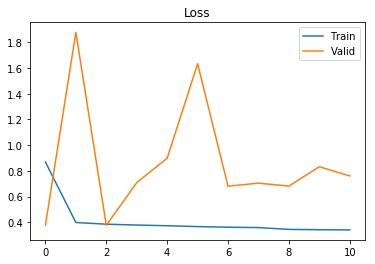

In [59]:
plt.plot(history.loss)
plt.plot(history.val_loss)
plt.legend(["Train", "Valid"])
plt.title("Loss")

In [60]:
valid_data_generator = valid_data.take(int(81251/batch_size)).make_one_shot_iterator()

In [64]:
y_pred_all  = []
y_seizure = []
with tf.Session() as sess:
    model = tf.keras.models.load_model("/home/ms994/dbmi_eeg_clustering/notebooks/seiz_3d_1output.h5", custom_objects={"f1":f1, "sensitivity":sensitivity, "specificity":specificity})
    test_iter =  valid_data.take(int(81251/batch_size)).make_one_shot_iterator()
    xy = test_iter.get_next()

    for i in range(1000):
        print(i)
        x = xy[0]
        y = xy[1]
        y_pred_all.append(model.predict(x, steps=1))
        y_seizure.append(y.eval())
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

OutOfRangeError: End of sequence
	 [[node IteratorGetNext_7 (defined at <ipython-input-64-946bfc27dfba>:7) ]]

Caused by op 'IteratorGetNext_7', defined at:
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-946bfc27dfba>", line 7, in <module>
    xy = test_iter.get_next()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

OutOfRangeError (see above for traceback): End of sequence
	 [[node IteratorGetNext_7 (defined at <ipython-input-64-946bfc27dfba>:7) ]]


In [68]:
y_pred_all = np.vstack(y_pred_all)

In [70]:
y_pred_all.shape

(40704, 2)

In [71]:
y_seiz_all = np.vstack(y_seizure)

In [78]:
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve

In [77]:
print(classification_report(y_pred_all[:40576].argmax(1), y_seiz_all.argmax(1)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     38140
           1       0.07      0.06      0.06      2436

    accuracy                           0.89     40576
   macro avg       0.50      0.50      0.50     40576
weighted avg       0.89      0.89      0.89     40576



In [82]:
y_seiz_all.argmax(1).shape

(40576,)

In [85]:
x_roc, y_roc, thresh_roc = roc_curve(y_seiz_all.argmax(1), y_pred_all[:40576,1])

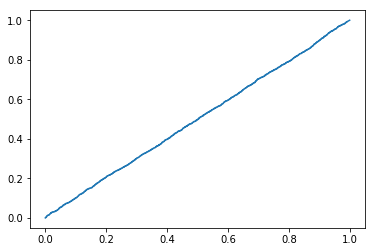

In [86]:
plt.plot(x_roc, y_roc)